In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from keras import layers
from PIL import Image
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random
import keras_cv

In [138]:
train_ds = image_dataset_from_directory(
    '../data/cinic-10_image_classification_challenge-dataset/train/',
    validation_split=0.2,
    subset='training',
    seed = 420,
    image_size=(32,32),
    batch_size=32,
    label_mode = 'categorical')

class_names = train_ds.class_names

val_ds = image_dataset_from_directory(
    '../data/cinic-10_image_classification_challenge-dataset/train/',
    validation_split=0.2,
    subset='validation',
    seed = 420,
    image_size=(32,32),
    batch_size=32,
    label_mode = 'categorical')

Found 90000 files belonging to 10 classes.
Using 72000 files for training.
Found 90000 files belonging to 10 classes.
Using 18000 files for validation.


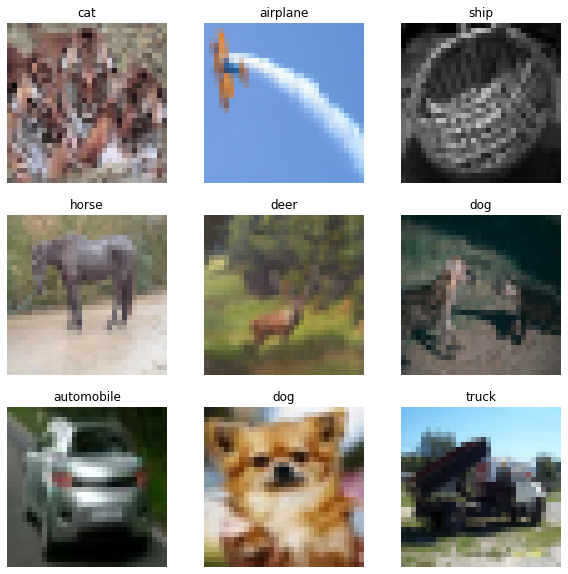

In [73]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# below code is for data augmentations, applied during training, on batches, as layers of the model.

there's several layers:
- RescaleLayer
- RotateLayer
- FlipLayer
- DecolorizeLayer
- GaussianNoiseLayer

we use those at the beginning of our model

In [74]:
# rescale to 0-1 range
RescaleLayer = layers.Rescaling(1./255)

### rotations

In [75]:
RotateLayer = layers.RandomRotation(0.2)

### Flipping

In [76]:
FlipLayer = layers.RandomFlip("horizontal")

### Decolorization

In [123]:
DecolorLayer = keras_cv.layers.Grayscale(output_channels=3)

### noise

In [129]:
GaussianNoise = layers.GaussianNoise(stddev = 0.1)

Text(0.5, 1.0, 'Noisy')

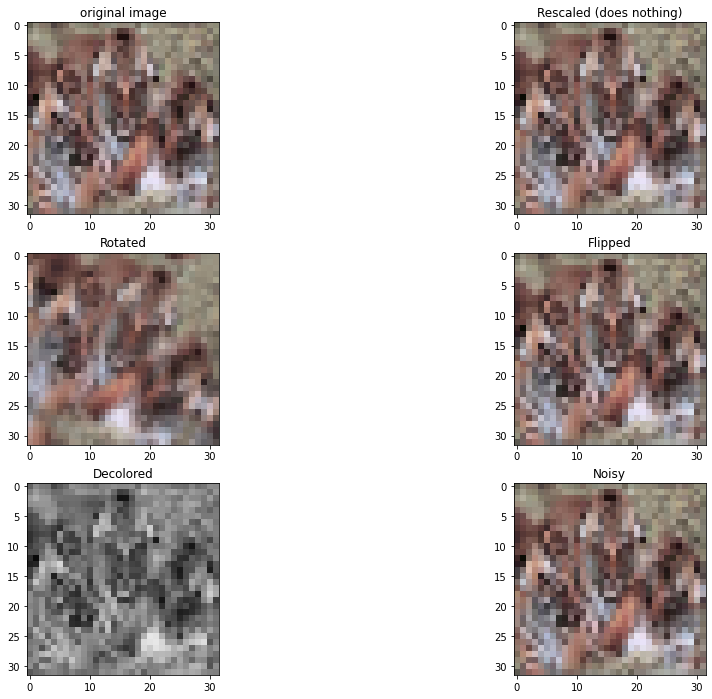

In [130]:
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name
        
image = images[0]
fig, axes = plt.subplots(3, 2, figsize = (16,12))
axes = axes.flatten()
axes[0].imshow(tf.cast(image, tf.uint8))
axes[0].set_title('original image')
for augmentationLayer, ax in zip([RescaleLayer, RotateLayer, FlipLayer, DecolorLayer, GaussianNoise], axes[1:]):
    ax.imshow(tf.cast(augmentationLayer(image), tf.uint8 if not augmentationLayer == RescaleLayer else tf.float32), cmap = 'grey' if augmentationLayer == DecolorLayer else None)
axes[1].set_title('Rescaled (does nothing)')
axes[2].set_title('Rotated')
axes[3].set_title('Flipped')
axes[4].set_title('Decolored')
axes[5].set_title('Noisy')

In [207]:
IMAGE_SIZE = 32
num_classes = 10
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
def to_dict(image, label):
    # image = tf.image.resize(image, IMAGE_SIZE)
    # image = tf.cast(image, tf.float32)
    # label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [208]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()

def cutmix(samples):
    samples = cut_mix(samples, training=True)
    return samples

def mixup(samples):
    samples = mix_up(samples, training=True)
    return samples

dict_train_ds = train_ds.map(to_dict, num_parallel_calls=AUTOTUNE)
# dict_train_ds = dict_train_ds.map(cutmix, num_parallel_calls=AUTOTUNE)
def dict_to_tuple(element):
    return element['images'], element['labels']

cutmixed_ds = dict_train_ds.map(dict_to_tuple)
mixup_ds = dict_train_ds.map(mixup, num_parallel_calls=AUTOTUNE).map(dict_to_tuple)

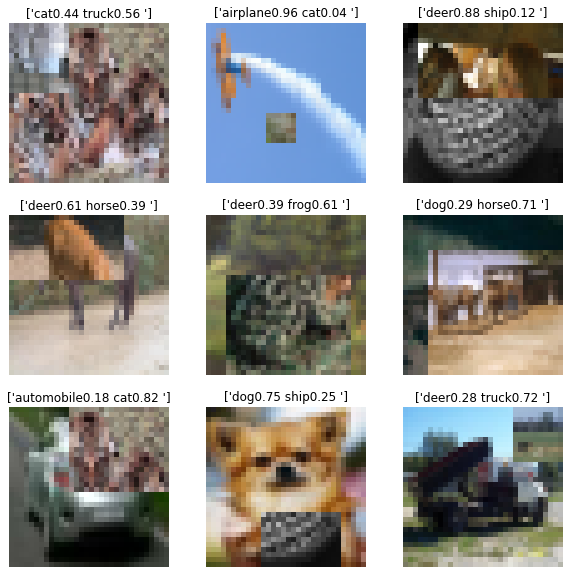

In [68]:
plt.figure(figsize=(10, 10))
for images, labels in cutmixed_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = ""
    for j, val in enumerate(labels[i]):
            if val > 0:
                label += class_names[j] + str(np.round(val, 2)) + " "
    plt.title([label])
    plt.axis("off")

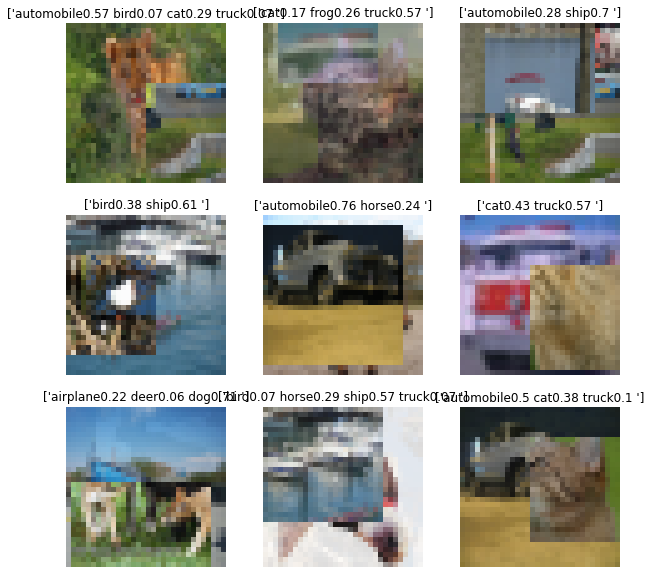

In [70]:
plt.figure(figsize=(10, 10))
for images, labels in mixup_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = ""
    for j, val in enumerate(labels[i]):
            if val > 0.02:
                label += class_names[j] + str(np.round(val, 2)) + " "
    plt.title([label])
    plt.axis("off")

In [83]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from keras import datasets, layers, models, losses, Model, utils
import time
import numpy as np

# rotation

In [89]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
inputs = layers.Input((32,32,3))
x = RotateLayer(inputs)

x = base_model50(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 243s 103ms/step - accuracy: 0.3276 - loss: 85.0461 - val_accuracy: 0.4273 - val_loss: 20.0862
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 206s 92ms/step - accuracy: 0.4238 - loss: 15.2783 - val_accuracy: 0.4541 - val_loss: 7.3129
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 207s 92ms/step - accuracy: 0.4411 - loss: 6.3979 - val_accuracy: 0.4581 - val_loss: 4.5207
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 219s 97ms/step - accuracy: 0.4503 - loss: 4.2172 - val_accuracy: 0.4673 - val_loss: 3.4850
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 191s 85ms/step - accuracy: 0.4569 - loss: 3.3513 - val_accuracy: 0.4700 - val_loss: 2.9664


In [90]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

# Pass the input through the Random Rotation layer
inputs = layers.Input(shape=(32, 32, 3))
x = RotateLayer(inputs)

# Continue with the existing model architecture
x = base_model101(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=5)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 328s 137ms/step - accuracy: 0.3165 - loss: 86.0850 - val_accuracy: 0.4215 - val_loss: 21.8614
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 301s 134ms/step - accuracy: 0.4162 - loss: 16.8654 - val_accuracy: 0.4408 - val_loss: 8.3962
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 328s 146ms/step - accuracy: 0.4322 - loss: 7.3333 - val_accuracy: 0.4523 - val_loss: 5.1676
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 330s 147ms/step - accuracy: 0.4444 - loss: 4.8006 - val_accuracy: 0.4573 - val_loss: 3.9362
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 304s 135ms/step - accuracy: 0.4478 - loss: 3.7553 - val_accuracy: 0.4545 - val_loss: 3.3080


# Flipping

In [91]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
inputs = layers.Input((32,32,3))
x = FlipLayer(inputs)

x = base_model50(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 182s 77ms/step - accuracy: 0.3858 - loss: 83.7080 - val_accuracy: 0.4884 - val_loss: 17.7718
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 172s 76ms/step - accuracy: 0.4925 - loss: 13.1117 - val_accuracy: 0.4982 - val_loss: 5.7786
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 171s 76ms/step - accuracy: 0.5109 - loss: 4.9486 - val_accuracy: 0.5096 - val_loss: 3.4737
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 164s 73ms/step - accuracy: 0.5179 - loss: 3.2083 - val_accuracy: 0.5123 - val_loss: 2.7231
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 168s 75ms/step - accuracy: 0.5196 - loss: 2.5860 - val_accuracy: 0.5122 - val_loss: 2.3673


In [92]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

# Pass the input through the Random Rotation layer
inputs = layers.Input(shape=(32, 32, 3))
x = FlipLayer(inputs)

# Continue with the existing model architecture
x = base_model101(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - accuracy: 0.3737 - loss: 84.7076 - val_accuracy: 0.4616 - val_loss: 19.4646
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 242s 108ms/step - accuracy: 0.4846 - loss: 14.6095 - val_accuracy: 0.4875 - val_loss: 6.7809
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 243s 108ms/step - accuracy: 0.5026 - loss: 5.8190 - val_accuracy: 0.4960 - val_loss: 4.0687
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 248s 110ms/step - accuracy: 0.5106 - loss: 3.7266 - val_accuracy: 0.5016 - val_loss: 3.1092
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 242s 108ms/step - accuracy: 0.5161 - loss: 2.9293 - val_accuracy: 0.5058 - val_loss: 2.6410


# Decolorization

In [131]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
inputs = layers.Input((32,32,3))
x = DecolorLayer(inputs)

x = base_model50(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 214s 90ms/step - accuracy: 0.3534 - loss: 83.4025 - val_accuracy: 0.4327 - val_loss: 17.0955
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 190s 85ms/step - accuracy: 0.4489 - loss: 12.5072 - val_accuracy: 0.4454 - val_loss: 5.4189
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 193s 86ms/step - accuracy: 0.4605 - loss: 4.6427 - val_accuracy: 0.4502 - val_loss: 3.3036
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 209s 93ms/step - accuracy: 0.4660 - loss: 3.0581 - val_accuracy: 0.4545 - val_loss: 2.6427
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 200s 89ms/step - accuracy: 0.4703 - loss: 2.5119 - val_accuracy: 0.4581 - val_loss: 2.3334


In [132]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

# Pass the input through the Random Rotation layer
inputs = layers.Input(shape=(32, 32, 3))
x = DecolorLayer(inputs)

# Continue with the existing model architecture
x = base_model101(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 305s 127ms/step - accuracy: 0.3402 - loss: 84.3515 - val_accuracy: 0.4279 - val_loss: 18.7851
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 286s 127ms/step - accuracy: 0.4448 - loss: 14.0286 - val_accuracy: 0.4429 - val_loss: 6.4473
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 306s 136ms/step - accuracy: 0.4631 - loss: 5.5473 - val_accuracy: 0.4478 - val_loss: 3.9312
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 292s 130ms/step - accuracy: 0.4693 - loss: 3.6193 - val_accuracy: 0.4522 - val_loss: 3.0647
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 292s 130ms/step - accuracy: 0.4739 - loss: 2.8963 - val_accuracy: 0.4543 - val_loss: 2.6452


# Noise

In [133]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
inputs = layers.Input((32,32,3))
inputs = RescaleLayer(inputs)
x = GaussianNoise(inputs)

x = base_model50(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 186s 78ms/step - accuracy: 0.3855 - loss: 83.6772 - val_accuracy: 0.4845 - val_loss: 17.7559
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 165s 73ms/step - accuracy: 0.4987 - loss: 13.0836 - val_accuracy: 0.5053 - val_loss: 5.7683
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 163s 72ms/step - accuracy: 0.5154 - loss: 4.9342 - val_accuracy: 0.5124 - val_loss: 3.4728
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 170s 75ms/step - accuracy: 0.5205 - loss: 3.1979 - val_accuracy: 0.5119 - val_loss: 2.7264
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 188s 84ms/step - accuracy: 0.5254 - loss: 2.5754 - val_accuracy: 0.5169 - val_loss: 2.3687


In [134]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

# Pass the input through the Random Rotation layer
inputs = layers.Input(shape=(32, 32, 3))
inputs = RescaleLayer(inputs)
x = GaussianNoise(inputs)

# Continue with the existing model architecture
x = base_model101(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 322s 134ms/step - accuracy: 0.3737 - loss: 84.6470 - val_accuracy: 0.4731 - val_loss: 19.4839
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 285s 126ms/step - accuracy: 0.4891 - loss: 14.6202 - val_accuracy: 0.4906 - val_loss: 6.8069
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 281s 125ms/step - accuracy: 0.5109 - loss: 5.8225 - val_accuracy: 0.4952 - val_loss: 4.0895
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 273s 121ms/step - accuracy: 0.5206 - loss: 3.7283 - val_accuracy: 0.5027 - val_loss: 3.1282
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 256s 114ms/step - accuracy: 0.5247 - loss: 2.9250 - val_accuracy: 0.5022 - val_loss: 2.6596


# CUTMIX

In [223]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
  
input_images = layers.Input((32, 32, 3), name = 'images')
input_labels = layers.Input((10,), name = 'labels')
# Apply CutMix to images here
inputs = keras_cv.layers.CutMix()({'images' : input_images, 'labels' : input_labels})['images']
x = base_model50(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 215s 91ms/step - accuracy: 0.3798 - loss: 83.6103 - val_accuracy: 0.4851 - val_loss: 17.2825
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 200s 89ms/step - accuracy: 0.4953 - loss: 12.6606 - val_accuracy: 0.5009 - val_loss: 5.4872
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 193s 86ms/step - accuracy: 0.5134 - loss: 4.7049 - val_accuracy: 0.5092 - val_loss: 3.3454
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 173s 77ms/step - accuracy: 0.5193 - loss: 3.1062 - val_accuracy: 0.5106 - val_loss: 2.6881
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 184s 82ms/step - accuracy: 0.5229 - loss: 2.5617 - val_accuracy: 0.5151 - val_loss: 2.3802


In [226]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

# Pass the input through the Random Rotation layer
input_images = layers.Input((32, 32, 3), name = 'images')
input_labels = layers.Input((10,), name = 'labels')
# Apply CutMix to images here
inputs = keras_cv.layers.CutMix()({'images' : input_images, 'labels' : input_labels})['images']

# Continue with the existing model architecture
x = base_model101(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 292s 121ms/step - accuracy: 0.3691 - loss: 84.6506 - val_accuracy: 0.4671 - val_loss: 19.5027
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 282s 125ms/step - accuracy: 0.4907 - loss: 14.6380 - val_accuracy: 0.4888 - val_loss: 6.8186
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 272s 121ms/step - accuracy: 0.5104 - loss: 5.8386 - val_accuracy: 0.4967 - val_loss: 4.0975
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 267s 119ms/step - accuracy: 0.5200 - loss: 3.7420 - val_accuracy: 0.5016 - val_loss: 3.1363
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 253s 112ms/step - accuracy: 0.5246 - loss: 2.9369 - val_accuracy: 0.5019 - val_loss: 2.6652


# combined augmentations

In [233]:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[keras_cv.layers.Grayscale(output_channels=3),
            layers.RandomRotation(0.2),
            layers.RandomFlip("horizontal"),
            layers.GaussianNoise(stddev = 0.1)
            ],
    augmentations_per_image=2,
)

def apply_pipeline(images):
    images = pipeline(images)
    return images

In [235]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
  
input_images = layers.Input((32, 32, 3), name = 'images')
input_labels = layers.Input((10,), name = 'labels')
# Apply CutMix to images here
inputs = keras_cv.layers.CutMix()({'images' : input_images, 'labels' : input_labels})['images']
inputs = layers.Lambda(apply_pipeline, output_shape=(32, 32, 3))(inputs) # rest of the augmentations here
x = base_model50(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 204s 86ms/step - accuracy: 0.3813 - loss: 83.4888 - val_accuracy: 0.4863 - val_loss: 17.0622
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 195s 87ms/step - accuracy: 0.4981 - loss: 12.4612 - val_accuracy: 0.4996 - val_loss: 5.3509
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 226s 100ms/step - accuracy: 0.5136 - loss: 4.5836 - val_accuracy: 0.5073 - val_loss: 3.2624
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 192s 85ms/step - accuracy: 0.5200 - loss: 3.0277 - val_accuracy: 0.5101 - val_loss: 2.6267
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 181s 80ms/step - accuracy: 0.5238 - loss: 2.5063 - val_accuracy: 0.5107 - val_loss: 2.3395


In [236]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

input_images = layers.Input((32, 32, 3), name = 'images')
input_labels = layers.Input((10,), name = 'labels')
# Apply CutMix to images here
inputs = keras_cv.layers.CutMix()({'images' : input_images, 'labels' : input_labels})['images']
inputs = layers.Lambda(apply_pipeline, output_shape=(32, 32, 3))(inputs) # rest of the augmentations here


x = base_model101(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 306s 128ms/step - accuracy: 0.3688 - loss: 84.5777 - val_accuracy: 0.4709 - val_loss: 19.2534
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 277s 123ms/step - accuracy: 0.4910 - loss: 14.4036 - val_accuracy: 0.4862 - val_loss: 6.6314
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 286s 127ms/step - accuracy: 0.5096 - loss: 5.6724 - val_accuracy: 0.4946 - val_loss: 3.9755
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 280s 124ms/step - accuracy: 0.5173 - loss: 3.6292 - val_accuracy: 0.5002 - val_loss: 3.0477
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 285s 127ms/step - accuracy: 0.5249 - loss: 2.8546 - val_accuracy: 0.5023 - val_loss: 2.6003


# long training

In [237]:
base_model50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model50.layers:
  layer.trainable = False
  
input_images = layers.Input((32, 32, 3), name = 'images')
input_labels = layers.Input((10,), name = 'labels')
# Apply CutMix to images here
inputs = keras_cv.layers.CutMix()({'images' : input_images, 'labels' : input_labels})['images']
inputs = layers.Lambda(apply_pipeline, output_shape=(32, 32, 3))(inputs) # rest of the augmentations here
x = base_model50(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model50 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model50.compile(optimizer="Adagrad", loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])

# Train model
history50 = head_model50.fit(train_ds, validation_data = val_ds, epochs=50)
head_model50.save_weights("head_model50_weights.h5")

Epoch 1/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - accuracy: 0.3761 - loss: 83.6253 - val_accuracy: 0.4829 - val_loss: 17.2503
Epoch 2/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 186s 83ms/step - accuracy: 0.4931 - loss: 12.6255 - val_accuracy: 0.4999 - val_loss: 5.4571
Epoch 3/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 190s 85ms/step - accuracy: 0.5123 - loss: 4.6791 - val_accuracy: 0.5023 - val_loss: 3.3293
Epoch 4/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 187s 83ms/step - accuracy: 0.5189 - loss: 3.0885 - val_accuracy: 0.5107 - val_loss: 2.6719
Epoch 5/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 187s 83ms/step - accuracy: 0.5246 - loss: 2.5490 - val_accuracy: 0.5119 - val_loss: 2.3690
Epoch 6/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 192s 85ms/step - accuracy: 0.5283 - loss: 2.2856 - val_accuracy: 0.5147 - val_loss: 2.1967
Epoch 7/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 186s 83ms/step - accuracy: 0.5304 - loss: 2.1296 - val_accuracy: 0.5124 - val_loss: 2.0876
Epoch 8/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy:

In [ ]:
# Load ResNet101 base model
base_model101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model101.layers:
    layer.trainable = False

input_images = layers.Input((32, 32, 3), name = 'images')
input_labels = layers.Input((10,), name = 'labels')
# Apply CutMix to images here
inputs = keras_cv.layers.CutMix()({'images' : input_images, 'labels' : input_labels})['images']
inputs = layers.Lambda(apply_pipeline, output_shape=(32, 32, 3))(inputs) # rest of the augmentations here


x = base_model101(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)
predictions = layers.Dense(10, activation='softmax')(x)

# Create model
head_model101 = Model(inputs=inputs, outputs=predictions)

# Compile model
head_model101.compile(optimizer="Adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history101 = head_model101.fit(train_ds, validation_data=val_ds, epochs=50)
head_model101.save_weights("head_model50_weights.h5")